In [16]:
# step 1: load + split data

# features:
#     HomeOdds
#     DrawOdds
#     AwayOdds
#     T_GoalsFor_H
#     T_GoalsAg_H
#     T_GoalsFor_A
#     T_GoalsAg_A
#     T_Points_H
#     T_Points_A
#     T_TablePosition_H
#     T_TablePosition_A
#     L3M_Points_H (L3M = last 3 matches)
#     L3M_Points_A

# y label (what we're predicting): goal difference

import numpy as np
import pandas as pd
import os
import datetime
import time
from utils import cleanDate

leagues = [
    'E0'
#     'D1'
#     'I1'
#     'SP1'
#     'F1'
]


def load(leagues, lossType):

    train = pd.read_csv(f'processedData/train_{leagues[0]}.csv')
    test = pd.read_csv(f'processedData/test_{leagues[0]}.csv')
    
    df = train.append(test)
    
    df.loc[:, 'Date'] = cleanDate(df.loc[:, 'Date'])
    
    dt = datetime.datetime(year=2019, month=7, day=1)
    
    df = df.loc[(df['T_GamesPlayed_H'] >= 3) & (df['T_GamesPlayed_A'] >= 3)]
    
    df = df.loc[df.loc[:,'FTR']==df.loc[:,'FTR'],:]

    ind = [i <= dt for i in df.loc[:, 'Date']]

    if lossType=='goals':
        y = df.loc[:, ['GoalsFor_H','GoalsFor_A']]

    elif lossType=='goaldif':
        y = df.loc[:, 'GoalsFor_H'] - df.loc[:, 'GoalsFor_A']

    else:
        y = df['FTR'].apply(lambda x: 2 if x == 'H' else (1 if x == 'D' else 0))

#     for i, col in enumerate(df.columns):
#         print(i, col)
        
    cols = list(range(15,18))+list(range(22,26))+list(range(34,38))+list(range(60,62))
    
    X = df.iloc[:,cols]
    
    X_train, X_test = X.loc[ind], X.loc[[i==False for i in ind]]
    y_train, y_test = y.loc[ind], y.loc[[i==False for i in ind]]
    
    train, test = df.loc[ind], df.loc[[i==False for i in ind]]
    
    return X_train, X_test, y_test, y_train, X, y, train, test, df


X_train, X_test, y_test, y_train, X, y, train, test, df = load(
    leagues=leagues, 
    lossType='goaldif'
)

X_test.tail()

,HomeOdds,DrawOdds,AwayOdds,T_GoalsFor_H,T_GoalsAg_H,T_GoalsFor_A,T_GoalsAg_A,T_Points_H,T_Points_A,T_TablePosition_H,T_TablePosition_A,L3M_Points_H,L3M_Points_A
335,0.1010,0.1710,0.1945,0.121212,0.175758,0.112121,0.139394,0.313131,0.464646,16,10,0.444444,0.777778
336,0.2995,0.2130,0.0780,0.106061,0.133333,0.218182,0.075758,0.363636,0.898990,15,1,0.444444,0.666667
337,0.2515,0.2000,0.0840,0.096970,0.178788,0.157576,0.133333,0.272727,0.484848,19,10,0.000000,0.666667
338,0.1035,0.1755,0.1810,0.121212,0.145455,0.127273,0.166667,0.444444,0.434343,11,13,0.666667,0.666667
339,0.4630,0.2575,0.0675,0.109091,0.187879,0.169697,0.100000,0.272727,0.555556,19,5,0.111111,1.000000


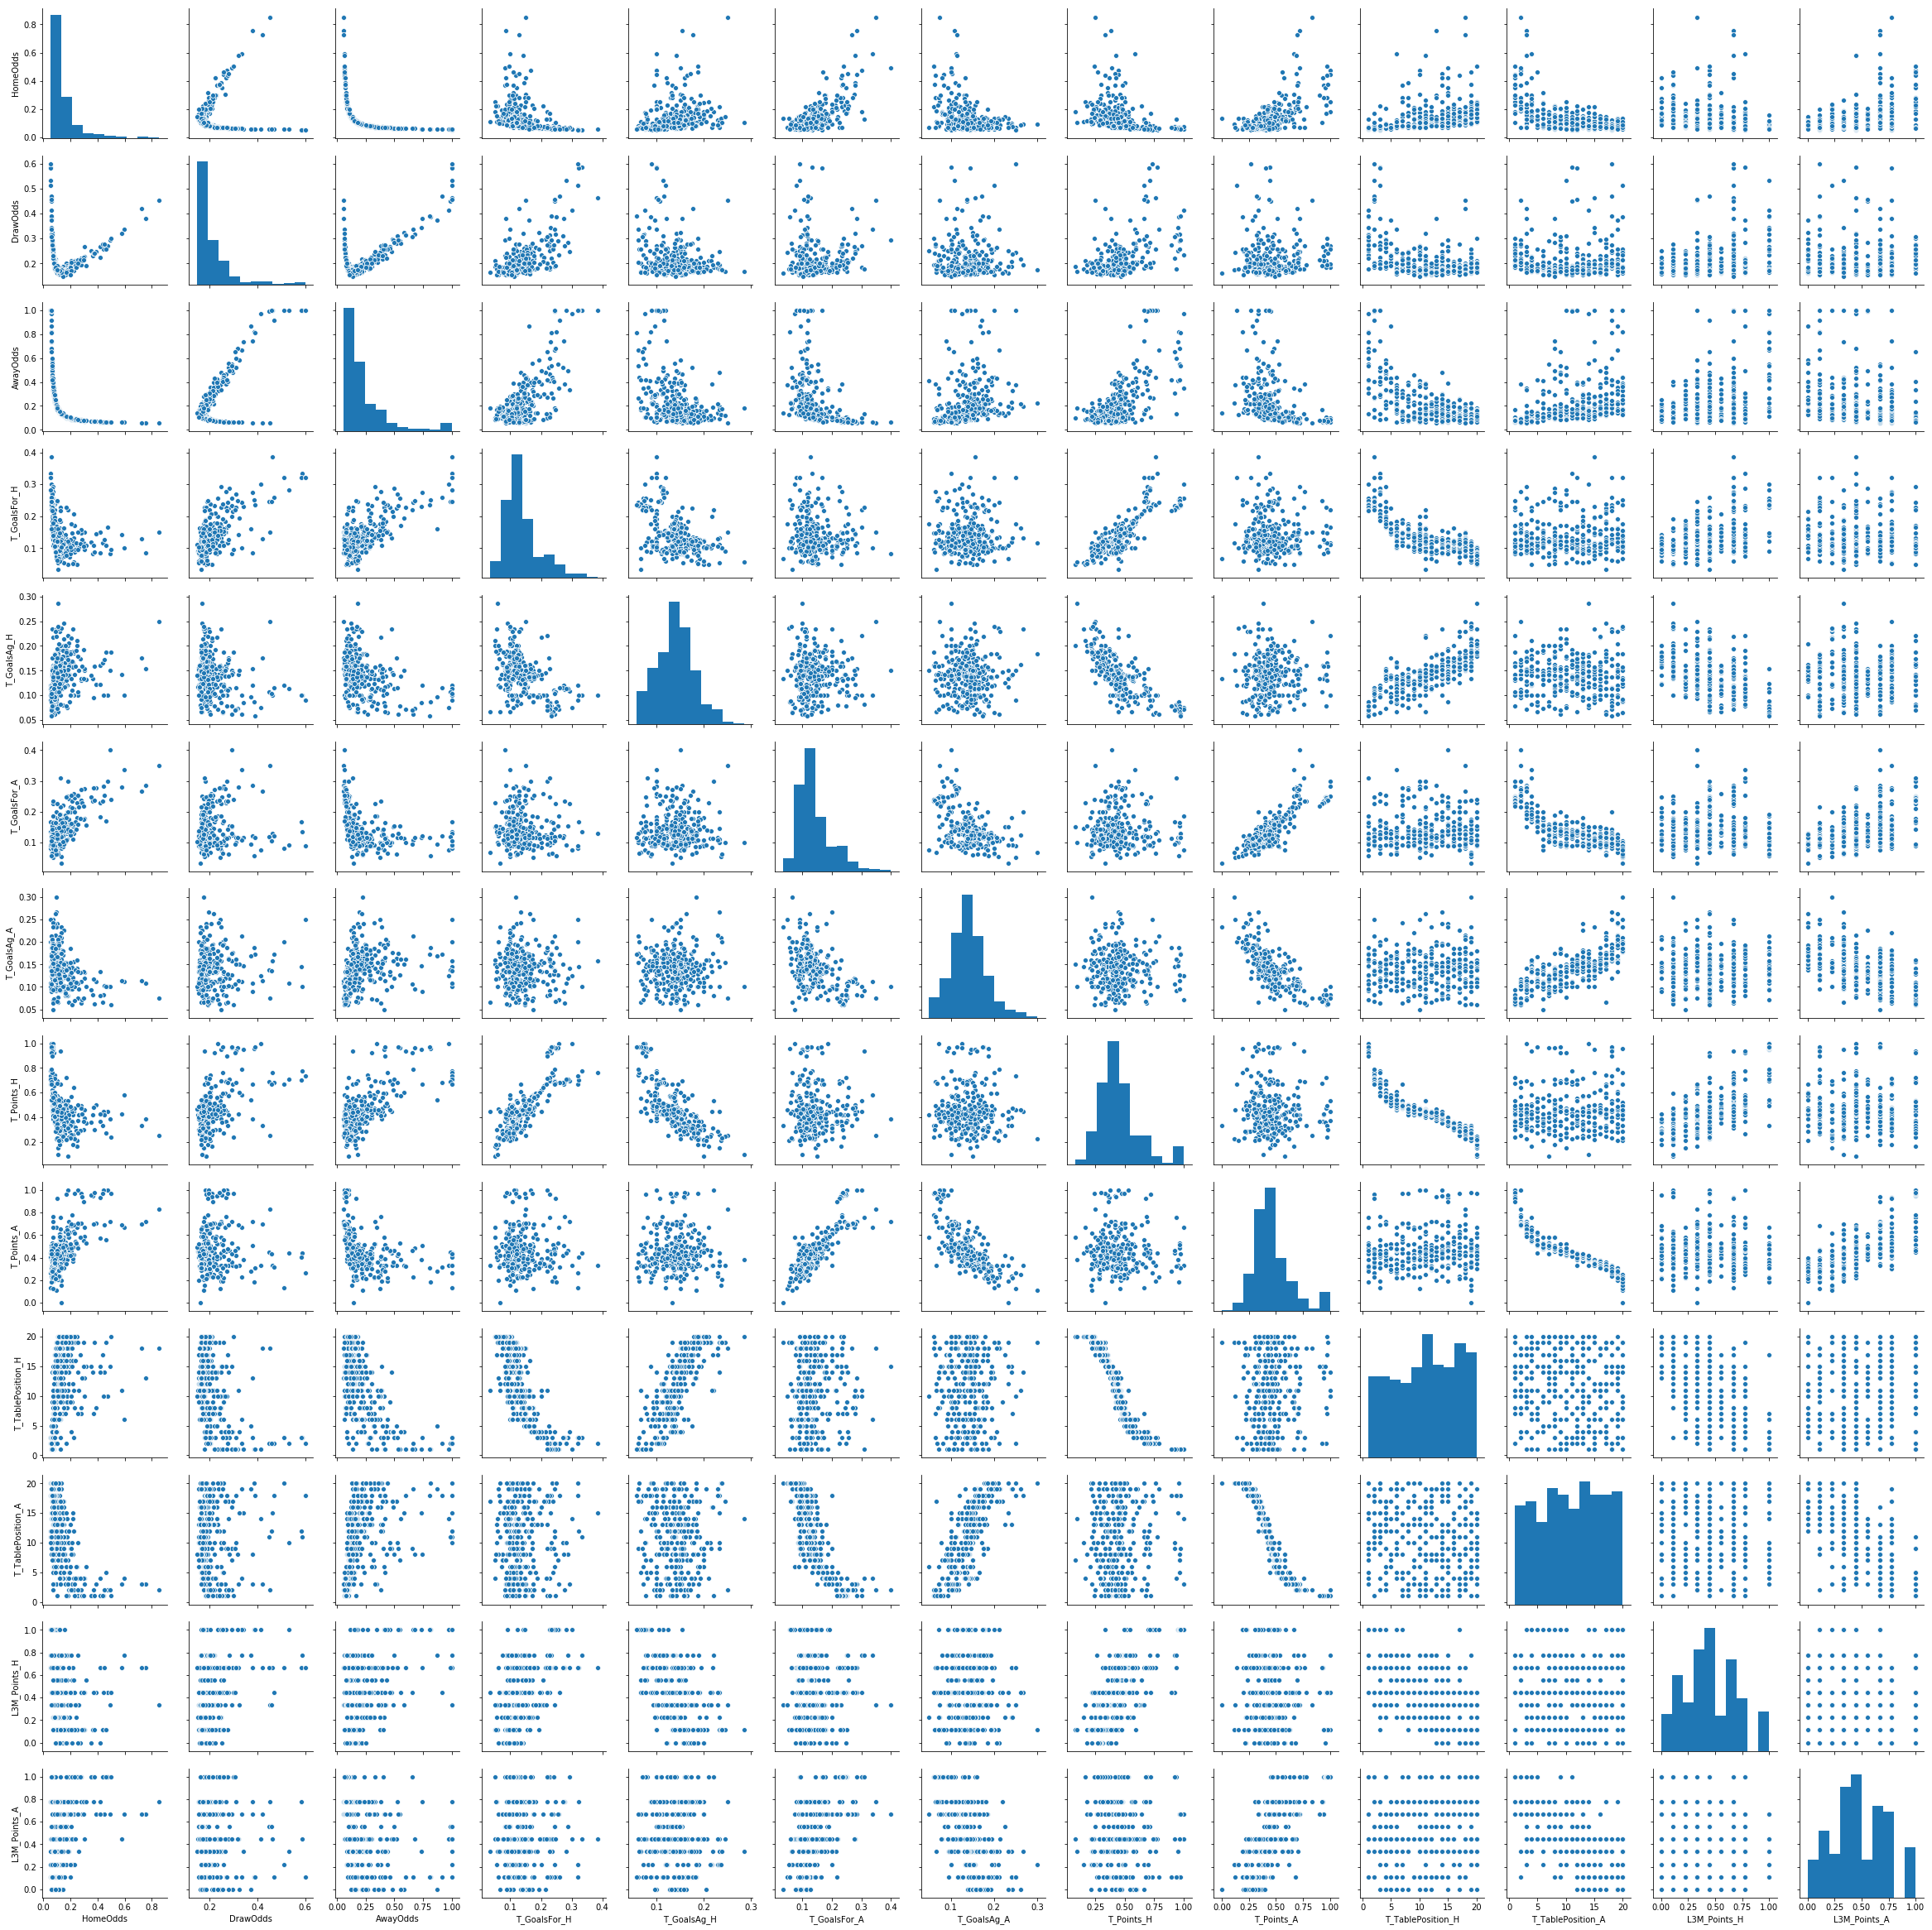

In [17]:
# step 2: quick eda via corrplot

import seaborn as sns
import matplotlib.pyplot as plt
 
sns.pairplot(X_test)
plt.show()

In [ ]:
# step 3: train xgb model
# why xgb: it's high performing and not interpretable. we want to use SHAP package later to interpret the model results

import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn
import shap

print(xgb.__version__)

param = {
    'objective': 'reg:squarederror',
    'eta': 0.2
}

num_round = 20

param['scale_pos_weight']= (y_train.size - y_train.sum()) / y_train.sum()

features = X_train.columns.values

xg_train = xgb.DMatrix(
    X_train.values, feature_names = features, label = y_train.values
)
xg_test = xgb.DMatrix(
    X_test.values, feature_names = features, label = y_test.values
)

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
reg = xgb.train(
    param, xg_train, num_round, watchlist, verbose_eval=True
)

preds = reg.predict(xg_test)

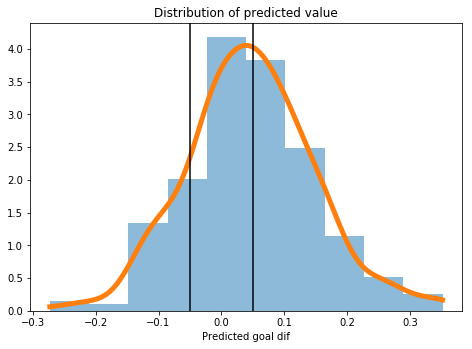

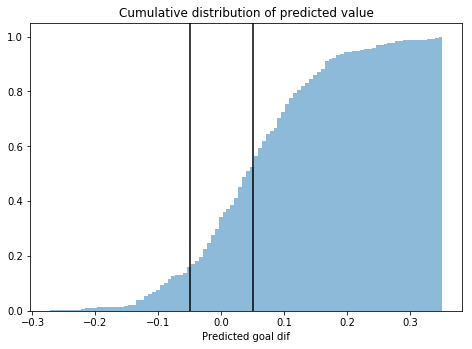

In [5]:
# step 4: visualize distribution of predictions. 
# we want normal distribution, with slight skew towards home wins, which we get

import matplotlib.pyplot as plt
import scipy.stats as st

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

kde_xs = np.linspace(min(preds), max(preds), 100)
kde = st.gaussian_kde(preds)

ax.hist(
    preds,
    alpha=0.5,
#     bins=25,
    density=True
)
ax.plot(
    kde_xs, 
    kde.pdf(kde_xs),
    linewidth=5
)

ax.axvline(x=-0.05, color='black')
ax.axvline(x=0.05, color='black')

plt.xlabel('Predicted goal dif')
plt.title('Distribution of predicted value')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.hist(
    preds,
    bins=100,
    cumulative=True,
    density=True,
    alpha=0.5
)

ax.axvline(x=-0.05, color='black')
ax.axvline(x=0.05, color='black')

plt.xlabel('Predicted goal dif')
plt.title('Cumulative distribution of predicted value')
plt.show()

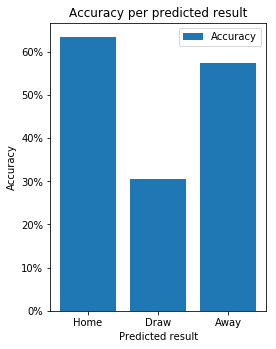

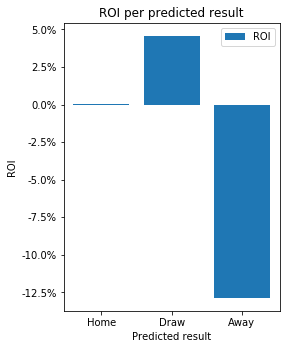

In [6]:
# step 5: visualize accuracy and returns
# we see a positive return on draws, even though draw accuracy is by far the lowest.

import matplotlib.ticker as mtick

preds = reg.predict(xg_test)

preds = [np.clip(int(i),-1,1) for i in np.round(preds*10)]

act = [np.clip(int(i),-1,1) for i in np.round(y_test*10)]

hOdds = X_test.loc[:, 'HomeOdds'].values
dOdds = X_test.loc[:, 'DrawOdds'].values
aOdds = X_test.loc[:, 'AwayOdds'].values

res = {}

for i in range(-1,2):
    res[i] = [0, 0, 0]

for i, j, h, d, a in zip(preds, act, hOdds, dOdds, aOdds):
    if i==j:
        res[i][0] += 1
        
        if i == 1:
            res[i][2] += h*20
        elif i == 0:
            res[i][2] += d*20
        elif i == -1:
            res[i][2] += a*20
        
    res[i][1] += 1
    res[i][2] -= 1
             
        
ret, acc = [], []

for k in res.keys():
    res[k][2] /= res[k][1]
    
    ret.append(res[k][2]*100)
    acc.append(res[k][0]*100/res[k][1])

ret, acc = ret[::-1], acc[::-1]

xlabs = ['Home','Draw','Away']

fig = plt.figure()
ax = fig.add_axes([0,0,0.5,1])

ax.bar(
    xlabs,
    acc,
    label='Accuracy'
)
ax.legend()

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Accuracy')
plt.xlabel('Predicted result')
plt.title('Accuracy per predicted result')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,0.5,1])

ax.bar(
    xlabs,
    ret,
    label='ROI'
)
ax.legend()


ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('ROI')
plt.xlabel('Predicted result')
plt.title('ROI per predicted result')
plt.show()

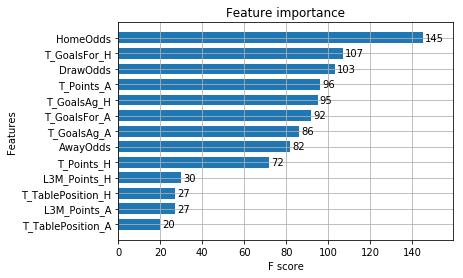

In [7]:
# step 6: feature importance using F score. this is directionless/magnitude feature importance, SHAP will let us understand how each variable affects model output

_ = plot_importance(reg, height=0.7)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


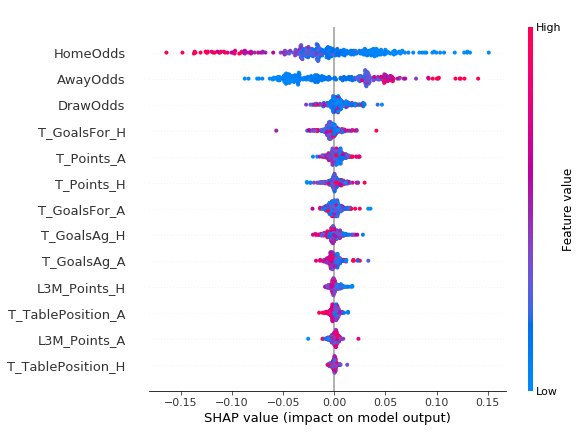

In [8]:
# step 7: summary plot using SHAP

explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

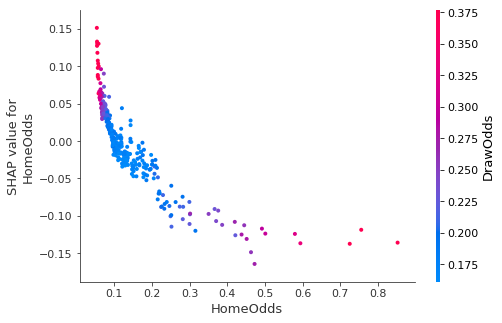

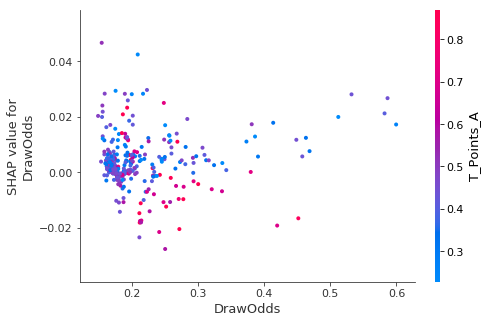

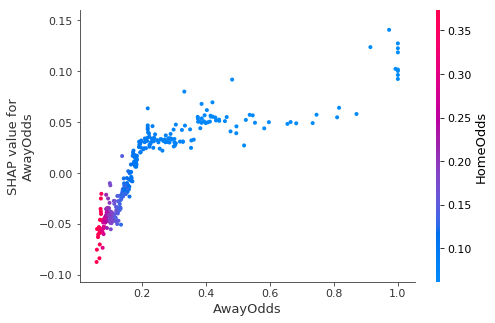

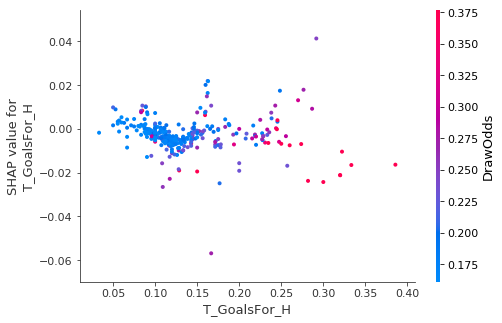

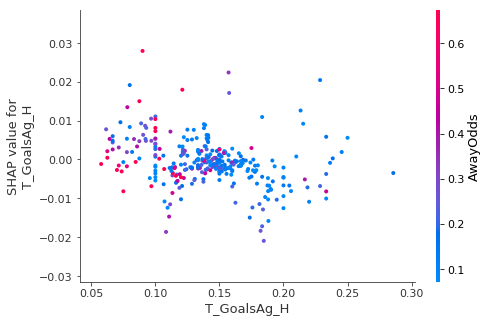

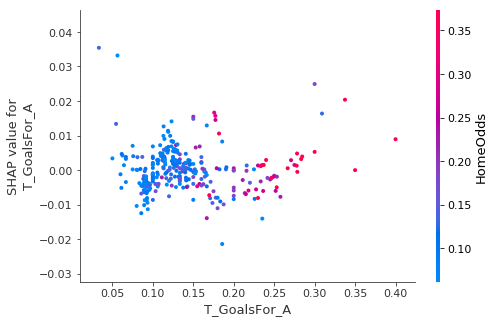

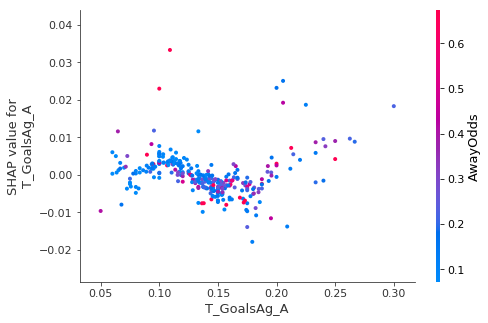

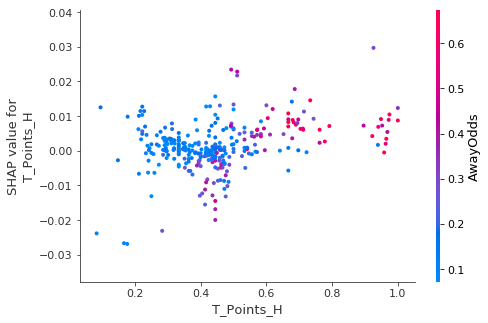

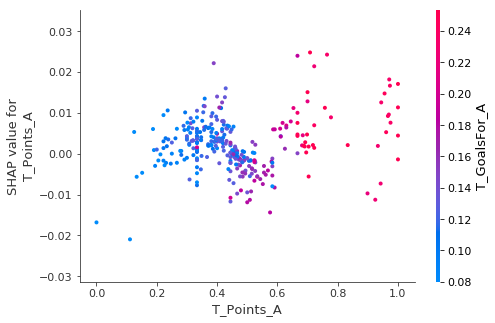

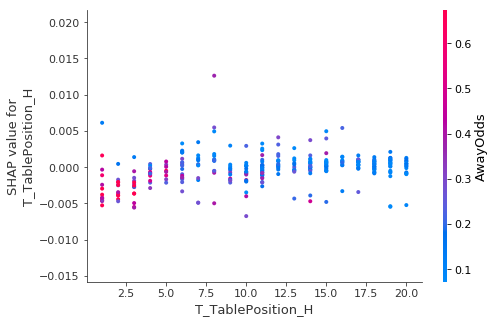

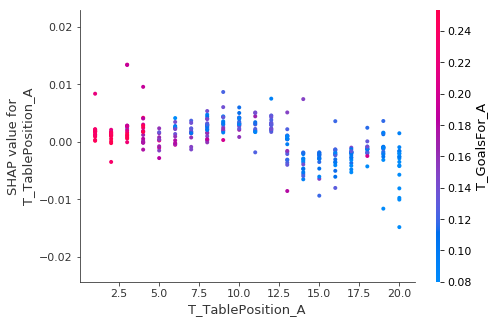

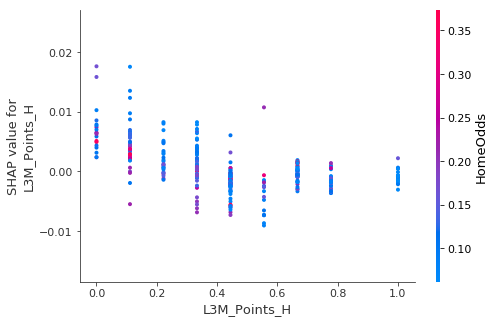

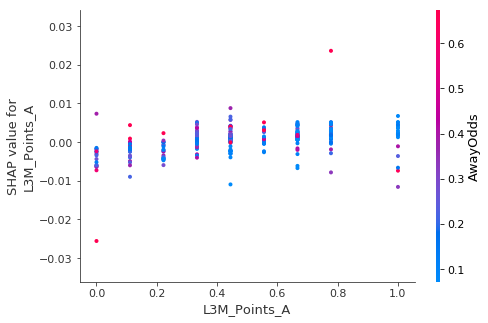

In [9]:
# step 8: SHAP values for each feature

for val in features:
    shap.dependence_plot(val, shap_values, X_test)

In [10]:
# step 9: local explanation examples. we will use these values in the web app to dynamically explain each prediction

shap.initjs()

i = -1

shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i, :])

In [11]:
shap.initjs()

i = -2

shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i, :])

In [12]:
shap.initjs()

i = -3

shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i, :])

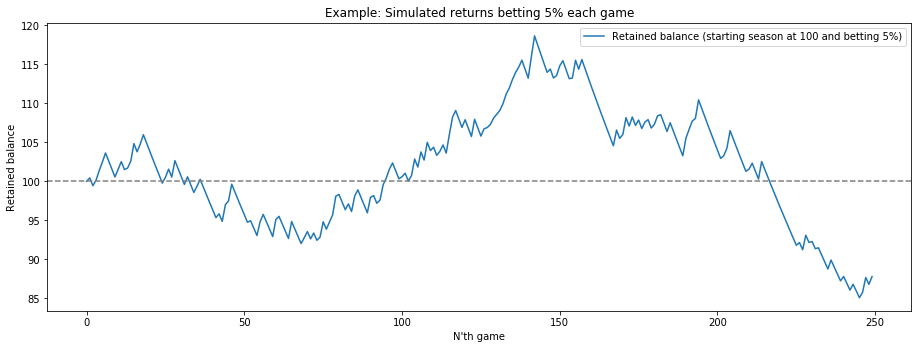

In [15]:
# further analysis: Should we optimize what share of out balance to bet on any given game?
# step 1: simulate return over a season

preds = reg.predict(xg_test)

preds = [np.clip(int(i),-1,1) for i in np.round(preds*10)]

act = [np.clip(int(i),-1,1) for i in np.round(y_test*10)]

hOdds = X_test.loc[:, 'HomeOdds'].values
dOdds = X_test.loc[:, 'DrawOdds'].values
aOdds = X_test.loc[:, 'AwayOdds'].values


def simulateReturns(preds, act, hOdds, dOdds, aOdds, balance=100, betShare=0.05, betOnlyThese={1,0,-1}):

    out = [balance]
    outRet = 0
    nGames = 0
    
    for i, j, h, d, a in zip(preds, act, hOdds, dOdds, aOdds):
        
        ret = -1
          
        if i not in betOnlyThese:
            ret += 1
        
        elif i==j:
            if i == 1:
                ret += h*20
            elif i == 0:
                ret += d*20
            elif i == -1:
                ret += a*20
                
            nGames += 1

        outRet += ret
        balance += balance*ret*betShare        
        out.append(balance)

    return out, outRet / nGames
    
simReturn, _ = simulateReturns(preds, act, hOdds, dOdds, aOdds, betShare=0.01)

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])

ax.plot(
    simReturn,
    label=f'Retained balance (starting season at 100 and betting 5%)'
)
ax.legend()

ax.axhline(y=100, color='grey', linestyle='dashed')

plt.title('Example: Simulated returns betting 5% each game')
plt.xlabel("N'th game")
plt.ylabel("Retained balance")
plt.show()

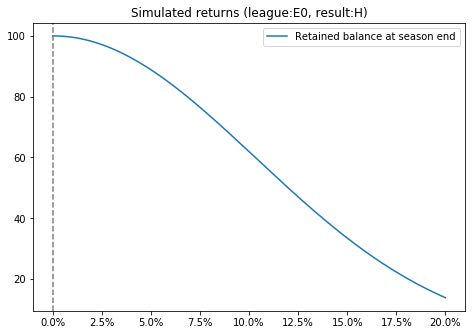

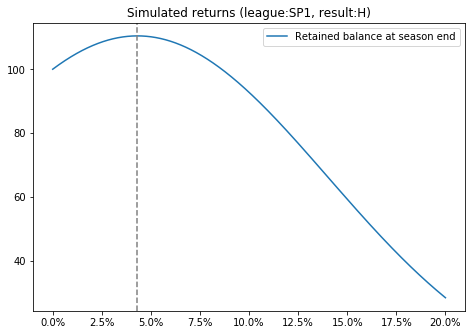

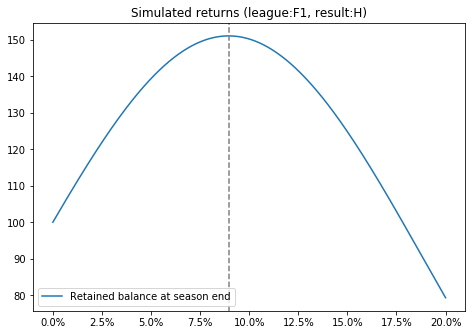

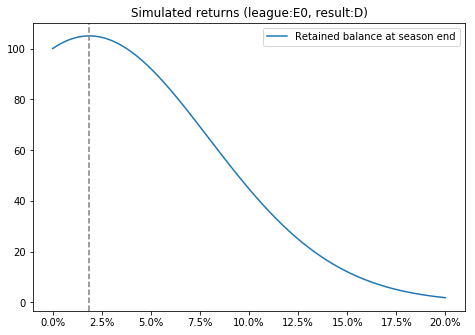

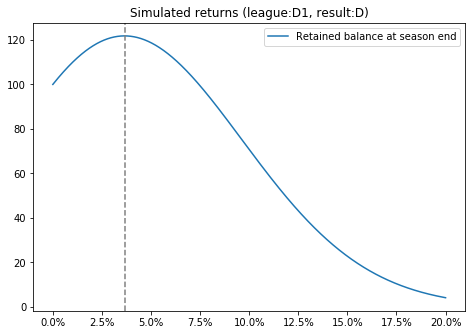

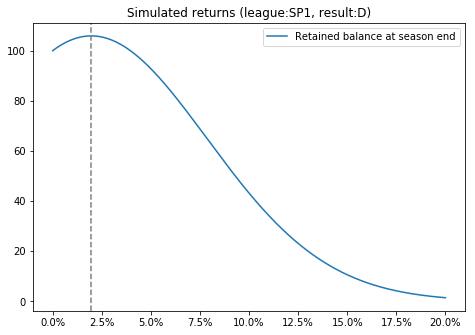

In [14]:
# step 2: generate cumulative return for each betting share value

leagues = [
    'E0',
    'D1',
    'I1',
    'SP1',
    'F1'
]

hda = {
    1: 'H',
    0: 'D',
    -1: 'A'
}

for bet in hda.keys():
    for league in leagues:
        
        preds, act, hOdds, dOdds, aOdds = [], [], [], [], []
    
        X_train, X_test, y_test, y_train, X, y, train, test, df = load(
            leagues=[league], 
            lossType='goaldif'
        )

        param = {
            'objective': 'reg:squarederror',
            'eta': 0.2
        }

        num_round = 20

        param['scale_pos_weight']= (y_train.size - y_train.sum()) / y_train.sum()

        features = X_train.columns.values

        xg_train = xgb.DMatrix(
            X_train.values, feature_names = features, label = y_train.values
        )
        xg_test = xgb.DMatrix(
            X_test.values, feature_names = features, label = y_test.values
        )

        watchlist = [(xg_train, 'train'), (xg_test, 'test')]
        reg = xgb.train(
            param, xg_train, num_round, watchlist, verbose_eval=False
        )

        tmp_preds = reg.predict(xg_test)

        preds += [np.clip(int(i),-1,1) for i in np.round(tmp_preds*10)]

        act += [np.clip(int(i),-1,1) for i in np.round(y_test*10)]

        hOdds += X_test.loc[:, 'HomeOdds'].tolist()
        dOdds += X_test.loc[:, 'DrawOdds'].tolist()
        aOdds += X_test.loc[:, 'AwayOdds'].tolist()

        simReturns, shares = [], []

        for i in range(2001):
            i /= 10000

            val, _ = simulateReturns(preds, act, hOdds, dOdds, aOdds, betShare=i, betOnlyThese={bet})

            shares.append(i*100)
            simReturns.append(val[-1])

        m = max(simReturns)
        maxInd = [i for i,j in enumerate(simReturns) if j==m]
        
        if shares[maxInd[0]] > 0 and shares[maxInd[0]] < 20:

            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])

            ax.plot(
                shares,
                simReturns,
                label=f'Retained balance at season end'
            )
            ax.legend()

            ax.axvline(x=shares[maxInd[0]], color='grey', linestyle='dashed')
            ax.xaxis.set_major_formatter(mtick.PercentFormatter())

            plt.title(f'Simulated returns (league:{league}, result:{hda[bet]})')
            plt.show()

While not scientific, we see that we should be betting 2-5% of our balance on any given game. I would stick to 2% as it's safer.